# SCS 3253: Machine Learning - Project

In [162]:
# === NOTEBOOK & IMPORT SETUP ===

# For data cleaning and conversion
import pandas as pd
from datetime import timedelta
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For assessing multicollinearity issue of the variables in the model
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For assessing dimensionality issues
from sklearn.decomposition import PCA

# For model metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For clustering, splitting train test dataset for training, and gridsearch for finding best hyperparameters
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, learning_curve, RandomizedSearchCV 

# For finding elbow point of the best number of clusters
from kneed import KneeLocator

# Non-linear regression models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb


# For Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

# Dataset: Doordash ETA Prediction
***
In this project, we will be using Doordash ETA prediction dataset (https://www.kaggle.com/datasets/dharun4772/doordash-eta-prediction/data) to predict the total seconds it takes from the time the order is created to the time the order is delivered. It is a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. Noise was added to the dataset to obfuscate certain business details.

The raw dataset of application record contains 197,428 rows and 16 columns. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds. The columns include:

- <b>Time features</b>
  - `market_id`: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
  - `created_at`: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
  - `actual_delivery_time`: Timestamp in UTC when the order was delivered to the consumer

- <b>Store features</b>
  - `store_id`: an id representing the restaurant the order was submitted for
  - `store_primary_category`: cuisine category of the restaurant, e.g., italian, asian
  - `order_protocol`: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

- <b>Order features</b>
  - `total_items`: total number of items in the order
  - `subtotal`: total value of the order submitted (in cents)
  - `num_distinct_items`: number of distinct items included in the order
  - `min_item_price`: price of the item with the least cost in the order (in cents)
  - `max_item_price`: price of the item with the highest cost in the order (in cents)

- <b>Market features</b> \
  DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):
  - `total_onshift_dashers`: Number of available dashers who are within 10 miles of the store at the time of order creation
  - `total_busy_dashers`: Subset of above total_onshift_dashers who are currently working on an order
  - `total_outstanding_orders`: Number of orders within 10 miles of this order that are currently being processed.

- <b>Predictions from other models</b> \
  We have predictions from other models for various stages of delivery process that we can use:
  - `estimated_order_place_duration`: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
  - `estimated_store_to_consumer_driving_duration`: Estimated travel time between store and consumer (in seconds)

## Loading the Dataset

In [2]:
doordash_data = pd.read_csv('historical_data.csv')

In [3]:
doordash_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


## Exploratory Data Analysis

In [4]:
doordash_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

### Data cleaning, outliers removal and feature engineering

Checking the unique values of market id and order protocol

In [5]:
doordash_data['market_id'].unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.])

In [6]:
doordash_data['order_protocol'].unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.,  7.])

Checking the count of missing values of market id, actual deliery time and order protocol

In [7]:
doordash_data['market_id'].isna().value_counts()

market_id
False    196441
True        987
Name: count, dtype: int64

In [8]:
doordash_data['actual_delivery_time'].isna().value_counts()

actual_delivery_time
False    197421
True          7
Name: count, dtype: int64

In [9]:
doordash_data['order_protocol'].isna().value_counts()

order_protocol
False    196433
True        995
Name: count, dtype: int64

There are not a lot of missing values in these columns, so they will just be removed.

In [10]:
doordash_data = doordash_data.dropna(subset=['market_id', 'actual_delivery_time', 'order_protocol'])

In [11]:
# Convert time from utc to pst
doordash_data['created_at_date_pst'] = pd.to_datetime(doordash_data['created_at']) - timedelta(hours=7)
doordash_data['actual_delivery_time_date_pst'] = pd.to_datetime(doordash_data['actual_delivery_time']) - timedelta(hours=7)
# Calculate the time in seconds needed for the order to be delivered from the time order is placed
doordash_data['total_time'] = (doordash_data['actual_delivery_time_date_pst'] - doordash_data['created_at_date_pst']).dt.seconds
# Adding new features to the dataset, the month, day of week and hour of the order
doordash_data['month'] = doordash_data['created_at_date_pst'].dt.month
doordash_data['day_of_week'] = doordash_data['created_at_date_pst'].dt.dayofweek
doordash_data['hour'] = doordash_data['created_at_date_pst'].dt.hour

Checking the unique values of number of busy, onshift dashers and total outstanding orders

In [12]:
doordash_data['total_onshift_dashers'].unique()

array([ 33.,   1.,   6.,   2.,  10.,   7.,   8.,   3.,  16.,   5.,   4.,
        24.,  12.,  19.,  21.,  22.,  27.,  13.,  18., 117., 130., 121.,
        34.,  17.,  38.,  20.,  15.,  39.,  26.,  30.,  35.,  11.,  14.,
        32.,  29.,  25.,  23.,  61.,  41.,  58.,  51.,  57.,  60.,   9.,
       108.,  72.,  89., 112.,  55., 126.,  80.,  69., 125., 113., 105.,
        98.,  86.,  90.,  87.,  74.,  84.,  91.,  96., 123., 101., 119.,
        nan, 129.,  66.,  81.,  75.,  43.,  70.,  65.,  77., 114.,  62.,
       116., 102.,  76.,  67.,  64.,  88.,  73.,  63.,  46.,  28.,  36.,
        47., 110.,  97.,  42.,  79.,  49.,  50.,  37.,  92., 103.,  44.,
        68.,  56.,   0., 107.,  94.,  78.,  71., 128., 104.,  45.,  31.,
       100.,  40.,  53., 115., 109.,  99.,  85.,  59., 118.,  54.,  52.,
        48., 132., 127., 133., 131., 149.,  93., 111.,  95.,  82., 136.,
       120., 134., 124., 106., 137.,  83., 152., 147., 144., 150., 145.,
       122., 155., 135., 151., 140., 141., 143., 13

In [13]:
doordash_data['total_busy_dashers'].unique()

array([ 14.,   2.,   0.,   1.,   6.,   9.,   8.,   3.,   5.,   4.,  24.,
        13.,  19.,  17.,  11.,  21.,  25.,  16.,  18.,  12., 112., 129.,
       119.,  30.,  15.,  33.,  22.,  37.,  29.,  23.,  31.,  34.,  20.,
        62.,  28.,  44.,  39.,  32.,  53.,  52.,  59.,  57.,   7.,  10.,
       100.,  72.,  81., 106.,  84., 122., 109.,  54.,  89., 103.,  91.,
        83.,  75., 107., 102.,  38.,  96.,  80.,  94.,  64., 117., 125.,
       110.,  nan, 128.,  27.,  35.,  70.,  74.,  73.,  40.,  97.,  77.,
        61.,  58., 116., 123.,  42.,  26.,  95.,  68., 108.,  55.,  78.,
        67.,  69.,  99.,  45.,  63.,  71.,  50.,  48.,  41.,  66., 127.,
        79.,  85.,  88.,  98., 118.,  90.,  36., 121.,  65.,  60.,  47.,
        49.,  43.,  46.,  93., 132., 104., 114., 124.,  56.,  51.,  76.,
       101.,  92., 130.,  86., 138., 136.,  82.,  87., 143., 120., 146.,
       131., 113., 115., 148., 105., 126., 141., 111., 135., 137., 133.,
        -1., 145., 139., 134., 142., 150., 144., 15

In [14]:
doordash_data['total_outstanding_orders'].unique()

array([ 21.,   2.,   0.,   9.,   7.,  18.,   1.,   4.,   3.,   8.,  12.,
        26.,  11.,  30.,  16.,  39.,  24.,  27.,  20.,  13., 178., 230.,
       205.,  28.,  15.,  42.,  43.,  33.,   5.,  37.,  46.,  36.,  14.,
        29.,  32.,  72.,  41.,  54.,  49.,  23.,  56.,  60.,  10.,   6.,
       154., 144.,  34., 100., 173.,  80., 202., 124., 130., 181., 188.,
       148., 150., 127., 160., 107., 123., 159., 186., 143., 190., 171.,
        nan, 261., 132.,  67., 120., 158.,  38.,  47.,  68.,  92.,  99.,
       175., 102., 184., 121.,  17.,  96., 111.,  22., 131., 141.,  89.,
        48.,  65., 194.,  73.,  45., 203., 134., 126., 183.,  64., 167.,
        31., 153., 119.,  75.,  95.,  52., 118., 191.,  61., 106.,  19.,
        58., 152., 101.,  35., 151.,  83., 179.,  97.,  44.,  25., 147.,
       169., 135., 142., 165., 172.,  91.,  40., 237., 198., 220., 219.,
        78.,  90., 138., 168.,  85.,  81., 212., 192., 137., 189.,  51.,
        74.,  59.,  62.,  63.,  50., 122.,  93.,  6

In [15]:
# Fill the missing values using the average number based on the combination of market, day of week and hour
doordash_data['total_onshift_dashers'].fillna(doordash_data.groupby(['day_of_week','hour','market_id'])['total_onshift_dashers'].transform('mean'), inplace=True)
doordash_data['total_busy_dashers'].fillna(doordash_data.groupby(['day_of_week','hour','market_id'])['total_busy_dashers'].transform('mean'), inplace=True)
doordash_data['total_outstanding_orders'].fillna(doordash_data.groupby(['day_of_week','hour','market_id'])['total_outstanding_orders'].transform('mean'), inplace=True)

Some values remain missing because there are no dashers and outstanding orders data for certain day of week and hour combinations. As a result, we will fill the remaining missing values using the average number based on the combination of market and hour only, because the numbers are more related to hours than the day of week.

In [16]:
# Fill the missing values using the average number based on the combination of market and hour
doordash_data['total_onshift_dashers'].fillna(doordash_data.groupby(['hour','market_id'])['total_onshift_dashers'].transform('mean'), inplace=True)
doordash_data['total_busy_dashers'].fillna(doordash_data.groupby(['hour','market_id'])['total_busy_dashers'].transform('mean'), inplace=True)
doordash_data['total_outstanding_orders'].fillna(doordash_data.groupby(['hour','market_id'])['total_outstanding_orders'].transform('mean'), inplace=True)

In [17]:
doordash_data['total_onshift_dashers'].isna().value_counts()

total_onshift_dashers
False    195924
True          2
Name: count, dtype: int64

In [18]:
# There are very few data left to be missnig, just drop them.
doordash_data = doordash_data.dropna(subset=['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'])

In [19]:
# Removing unreasonable data, as the number of dashers and orders can never be less than 0
doordash_data = doordash_data[(doordash_data['total_onshift_dashers'] >= 0) & 
                         (doordash_data['total_busy_dashers'] >= 0) & 
                         (doordash_data['total_outstanding_orders'] >= 0)]

In [20]:
# Calculate the ratio of busy dashers out of the onshift dashers
doordash_data['busy_dashers_ratio'] = doordash_data['total_busy_dashers'] / doordash_data['total_onshift_dashers']

In [21]:
# Removing unreasonable data, as the ratio of busy dashers can never be less than 0 and more than 1
doordash_data = doordash_data[(doordash_data['busy_dashers_ratio'] <= 1) & (doordash_data['busy_dashers_ratio'] >= 0)]

In [22]:
'''
Function defined to plot boxplot to examine outliers of each column
'''
def plot_boxplot(column):
    plt.boxplot(doordash_data[column])
    fig = plt.figure(figsize =(10, 7))
    plt.show()

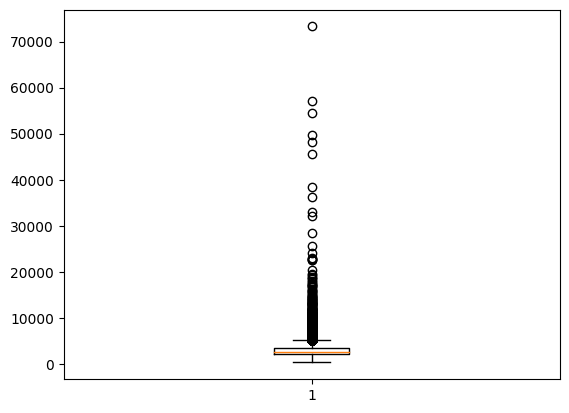

<Figure size 1000x700 with 0 Axes>

In [23]:
# Examine outliers of total time
plot_boxplot('total_time')

The total time is the target variable. It's easy to have bias if we have outliers, so we are removing all the outliers that are out of the interquartile range.

In [24]:
doordash_data = doordash_data[(doordash_data['total_time'] < 5040) & (doordash_data['total_time'] > 297)]

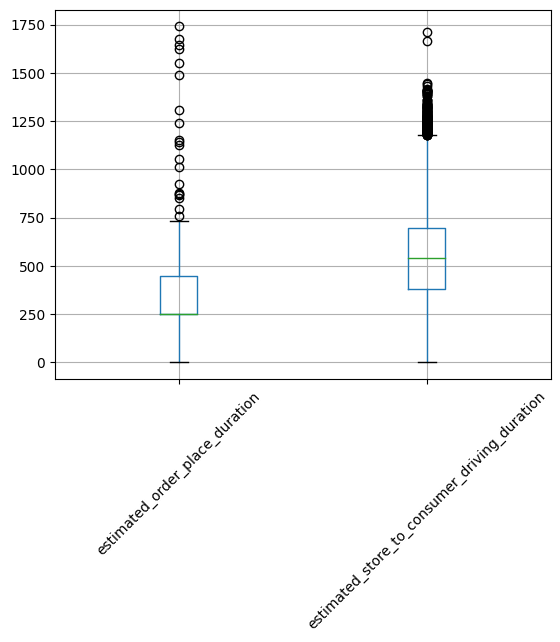

In [25]:
doordash_data[['estimated_order_place_duration', 
               'estimated_store_to_consumer_driving_duration']].boxplot(rot=45)
plt.show()

The estimated order place duration and estimated store to consumer driving duration times are from other two predicted models. These two times are part of the total time, the target variable. It's easy to have bias also if we have outliers, so we are removing all the outliers that are out of the interquartile range.

In [26]:
doordash_data = doordash_data[(doordash_data['estimated_order_place_duration'] < 761) & 
                         (doordash_data['estimated_store_to_consumer_driving_duration'] < 1175)]

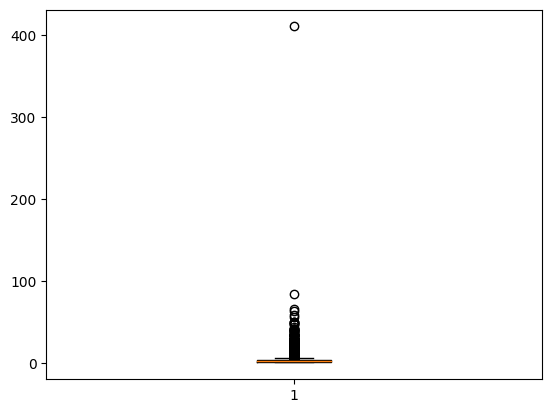

<Figure size 1000x700 with 0 Axes>

In [27]:
# Examine outliers of total items
plot_boxplot('total_items')

We are just removing extreme outliers in this case because it could better explain how more total number of items could contribute to longer total delviery time

In [28]:
doordash_data = doordash_data[doordash_data['total_items'] < 100]

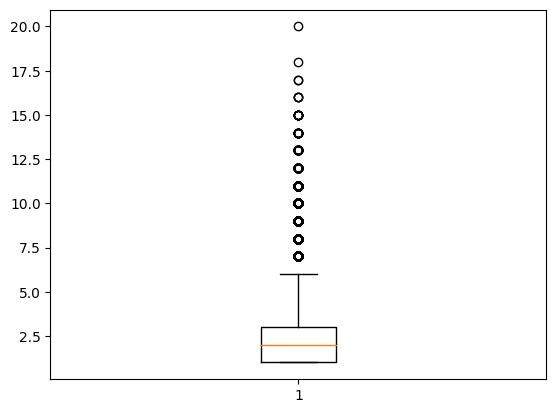

<Figure size 1000x700 with 0 Axes>

In [29]:
# Examine outliers of number of distinct items
plot_boxplot('num_distinct_items')

There's nothing we need to do with number of distinct items because there are no extreme outliers

Total number of items is very similar to number of distinct items, so there is no point to include both in the model. Instead, a new variable should be created based on the distinct items. In this case, a variable that indicates whether all the items in the order are distinct or not

In [30]:
doordash_data['all_items_distinct'] = doordash_data['num_distinct_items'] == doordash_data['total_items']

In [31]:
doordash_data['all_items_distinct'] = doordash_data['all_items_distinct'].astype(int)

In [32]:
doordash_data['all_items_distinct'].value_counts()

all_items_distinct
1    105233
0     37760
Name: count, dtype: int64

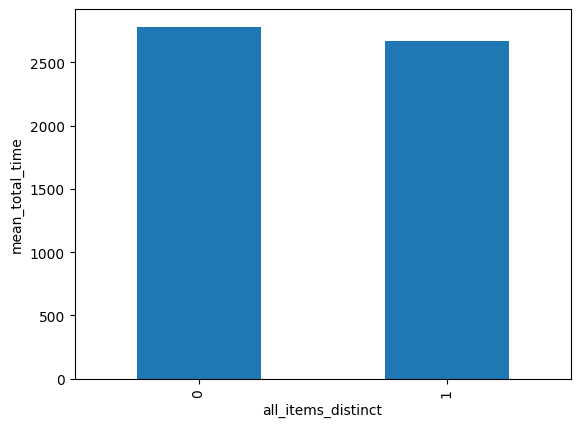

In [33]:
doordash_data.groupby('all_items_distinct')['total_time'].mean().plot.bar()
plt.ylabel('mean_total_time')
plt.show()

From the graph above, it shows that the mean of the total delivery time in the situation where all items in the order are distinct is slightly higher.

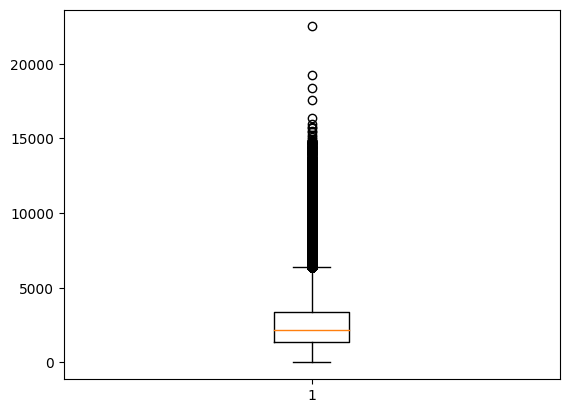

<Figure size 1000x700 with 0 Axes>

In [34]:
# Examine outliers of subtotal
plot_boxplot('subtotal')

Similar to total items, wee are just removing extreme outliers of subtotal because it is a key to explain how higher value of an order contribute to longer total delviery time

In [35]:
doordash_data = doordash_data[doordash_data['subtotal'] < 20000]

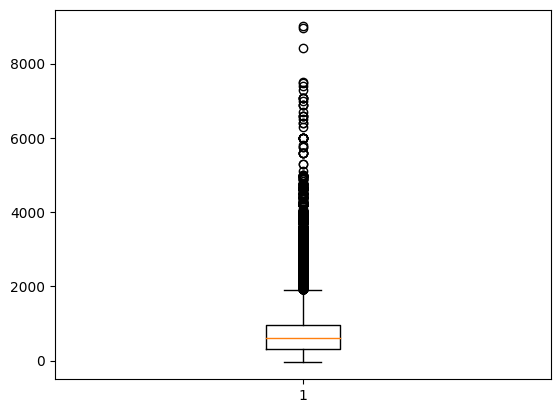

<Figure size 1000x700 with 0 Axes>

In [36]:
# Examine outliers of minimum item price
plot_boxplot('min_item_price')

In [37]:
doordash_data = doordash_data[(doordash_data['min_item_price'] < 8000) & (doordash_data['min_item_price'] > 0)]

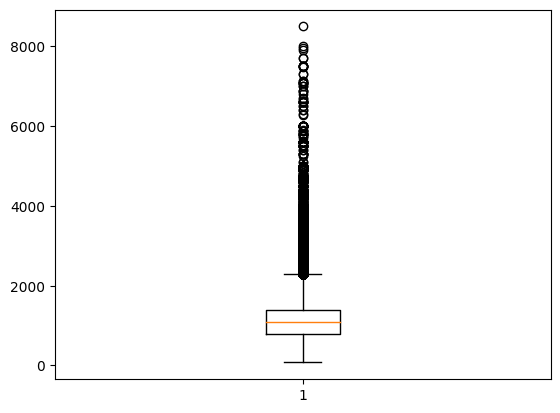

<Figure size 1000x700 with 0 Axes>

In [38]:
# Examine outliers of maximum item price
plot_boxplot('max_item_price')

In [39]:
doordash_data = doordash_data[(doordash_data['max_item_price'] < 8000) & (doordash_data['max_item_price'] > 0)]

We are just removing the extreme outliers of the maximum and minimum item price values because we won't be directly using these two variables in the model, as they have a high correlation with the subtotal variable. We are also removing the maximum and minimum item price that are less than 0.

In [40]:
# Remove unreasonable data as the maximum item price shouldn't be greater than subtotal
doordash_data = doordash_data.drop(doordash_data[doordash_data['max_item_price'] > doordash_data['subtotal']].index)

We are adding a variable to check if the maximum item price and minimum item price is the same. This could help us understand if the order is only for one single type of item or multiple types.

In [41]:
doordash_data['max_min_price_same'] = doordash_data['max_item_price'] == doordash_data['min_item_price']

In [42]:
doordash_data['max_min_price_same'] = doordash_data['max_min_price_same'].astype(int)

In [43]:
doordash_data['max_min_price_same'].value_counts()

max_min_price_same
0    102487
1     38281
Name: count, dtype: int64

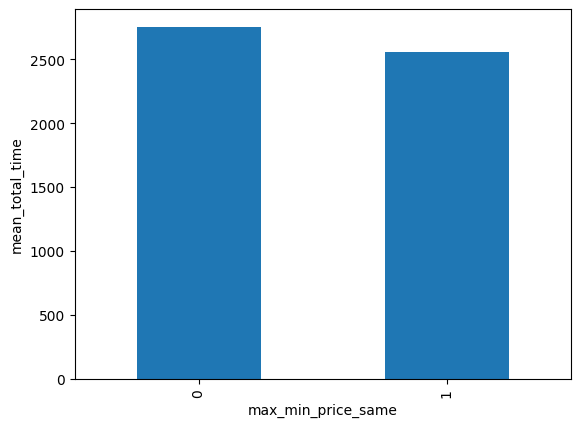

In [44]:
doordash_data.groupby('max_min_price_same')['total_time'].mean().plot.bar()
plt.ylabel('mean_total_time')
plt.show()

It shows that the average time it takes to deliver one type of item is higher than the time it takes to deliver different items. That is pretty unexpected because the time it takes to prepare multiple types of items should be longer.

In [45]:
doordash_data['store_primary_category'].unique()

array(['american', nan, 'indian', 'italian', 'mexican', 'sandwich',
       'thai', 'cafe', 'pizza', 'chinese', 'singaporean', 'burger',
       'breakfast', 'mediterranean', 'greek', 'catering', 'filipino',
       'japanese', 'other', 'vegan', 'asian', 'barbecue', 'fast',
       'dessert', 'smoothie', 'seafood', 'vietnamese',
       'convenience-store', 'cajun', 'steak', 'middle-eastern', 'soup',
       'vegetarian', 'salad', 'persian', 'korean', 'sushi',
       'latin-american', 'hawaiian', 'chocolate', 'british', 'nepalese',
       'pasta', 'alcohol', 'turkish', 'dim-sum', 'malaysian', 'ethiopian',
       'afghan', 'bubble-tea', 'burmese', 'german', 'peruvian', 'french',
       'caribbean', 'gluten-free', 'comfort-food', 'pakistani',
       'moroccan', 'spanish', 'gastropub', 'southern', 'tapas', 'russian',
       'brazilian', 'european', 'cheese', 'african', 'argentine', 'irish',
       'lebanese', 'kosher', 'belgian', 'indonesian', 'alcohol-plus-food'],
      dtype=object)

In [46]:
doordash_data['store_primary_category'].isna().value_counts()

store_primary_category
False    137825
True       2943
Name: count, dtype: int64

There are not a lot of missing food category in the dataset, so we will just drop them. If we fill them by picking categories randomly, it could cause bias

In [47]:
doordash_data = doordash_data.dropna(subset=['store_primary_category'])

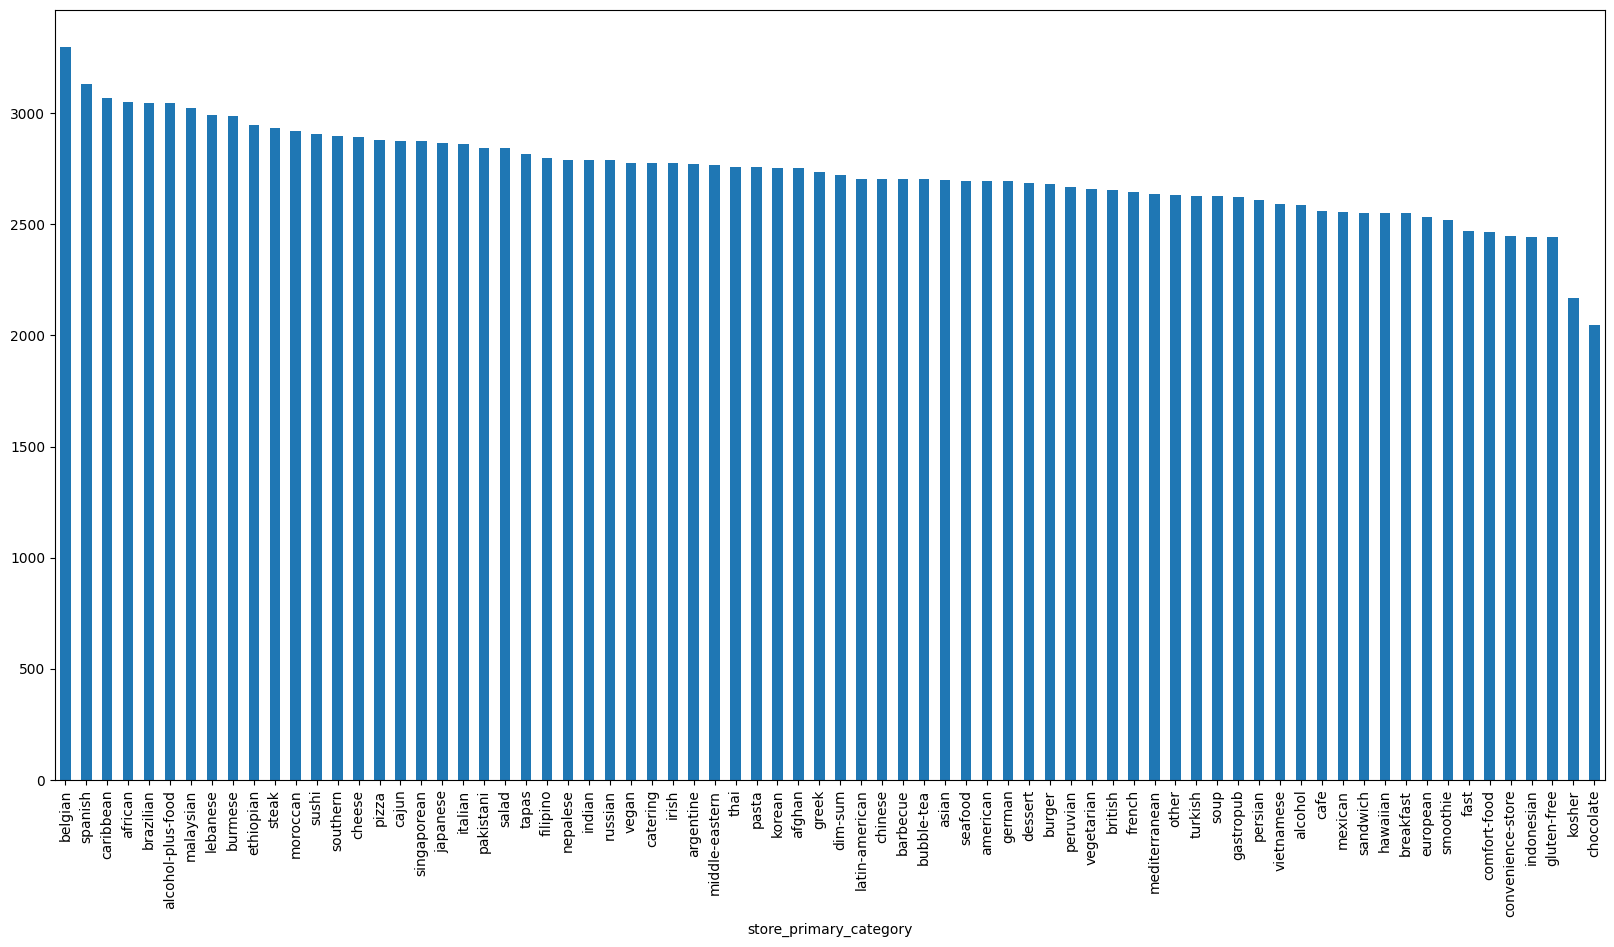

In [48]:
doordash_data.groupby(['store_primary_category'])['total_time'].mean().sort_values(ascending = False).plot.bar(figsize=(20,10))
plt.show()

For different primary food categories, they have different mean total delivery time. Because there are too many of them, we want to put them in clusters based on the mean total delivery time

### Clustering for adding a new feature variable

In [49]:
# Get the mean total time of each primary category
mean_total_time = doordash_data.groupby('store_primary_category')['total_time'].mean().reset_index()
mean_total_time.columns = ['store_primary_category', 'mean_total_time']

In [50]:
# Scale the data for clustering
scaler = StandardScaler()
mean_prep_time_scaled = scaler.fit_transform(mean_total_time[['mean_total_time']])

In [51]:
inertia = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(mean_prep_time_scaled)
    inertia.append(kmeans.inertia_)

In [52]:
kneedle = KneeLocator(range(1, 21), inertia, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow
print(f'The elbow point is at k = {elbow_point}')

The elbow point is at k = 5


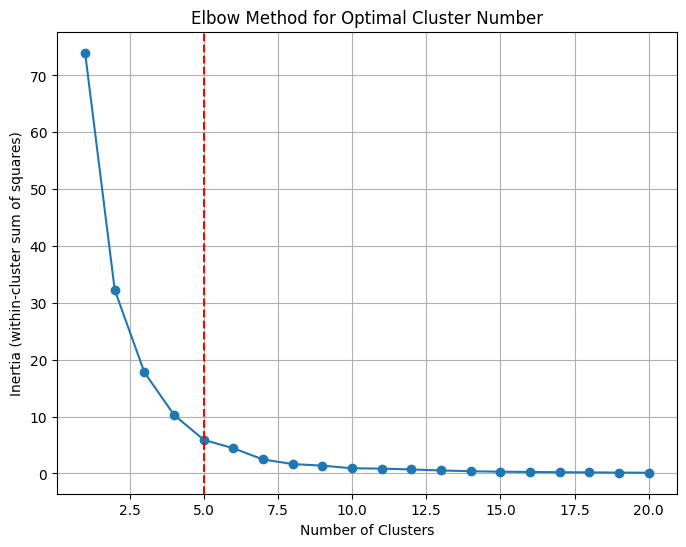

In [53]:
# Elbow Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), inertia, marker='o')
plt.axvline(x=elbow_point, color='red', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for Optimal Cluster Number')
plt.grid(True)
plt.show()

Based on the elbow analysis, the best number of clusters is 5

In [54]:
kmeans_final = KMeans(n_clusters=elbow_point, random_state=42)
mean_total_time['category_cluster'] = kmeans_final.fit_predict(mean_prep_time_scaled)
print(mean_total_time.groupby('category_cluster')['store_primary_category'].value_counts())

category_cluster  store_primary_category
0                 alcohol                   1
                  breakfast                 1
                  vietnamese                1
                  smoothie                  1
                  sandwich                  1
                                           ..
4                 greek                     1
                  german                    1
                  gastropub                 1
                  french                    1
                  vegetarian                1
Name: count, Length: 74, dtype: int64


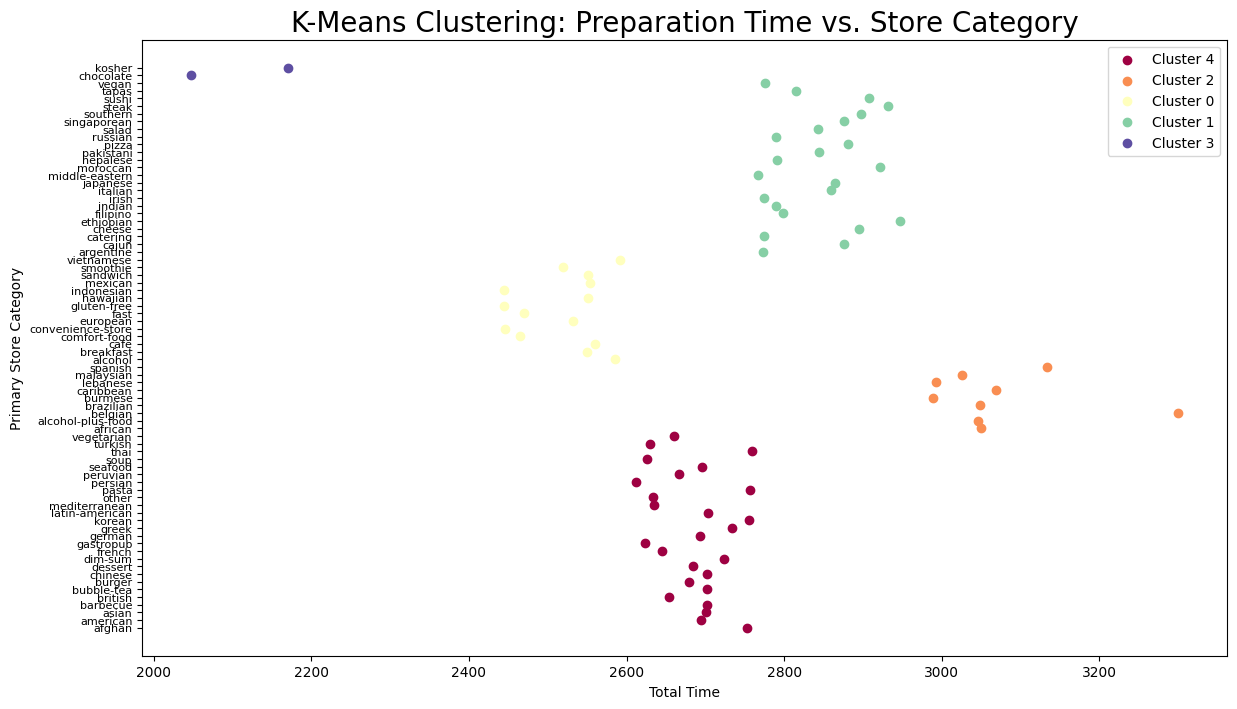

In [55]:
# Plot the primray store category in cluster in the plot to visualize what each cluster is about
plt.figure(figsize=(14, 8))

unique_clusters = mean_total_time['category_cluster'].unique()
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

# Cluster in different colours, category within the same cluster in the same colour
for cluster, color in zip(unique_clusters, colors):
    cluster_data = mean_total_time[mean_total_time['category_cluster'] == cluster]
    plt.scatter(cluster_data['mean_total_time'], cluster_data['store_primary_category'], color=color, label=f'Cluster {cluster}')

plt.xlabel('Total Time')
plt.ylabel('Primary Store Category')
plt.title('K-Means Clustering: Preparation Time vs. Store Category', fontsize = 20)
plt.tick_params(axis='y', labelsize=8)
plt.grid(False)
plt.legend()
plt.show()

This graph shows that we group the store category by 5 clusters based on the mean total time. There are categories with extreme low and high mean delivery time, and they belong to 2 different clusters. Quite a few number of store categories have similar mean total time, and they are grouped into 3 other clusters based on the mean total time.

In [56]:
# Mapping the cluster to each order in the main dataframe based on what the associated primary store category is
cat_cluster_dict = pd.Series(mean_total_time['category_cluster'].values, index=mean_total_time['store_primary_category']).to_dict()
doordash_data['category_cluster'] = doordash_data['store_primary_category'].map(cat_cluster_dict)

In [57]:
# We are still keeping the store primary category as a feature, so we are turning them into labels, otherwise it can't be fit
# into the model
le = LabelEncoder()
label = le.fit_transform(doordash_data['store_primary_category'])
doordash_data.loc[:, 'store_primary_category_label'] = label

### Contribution of each feature towards the output

<Axes: xlabel='subtotal', ylabel='total_time'>

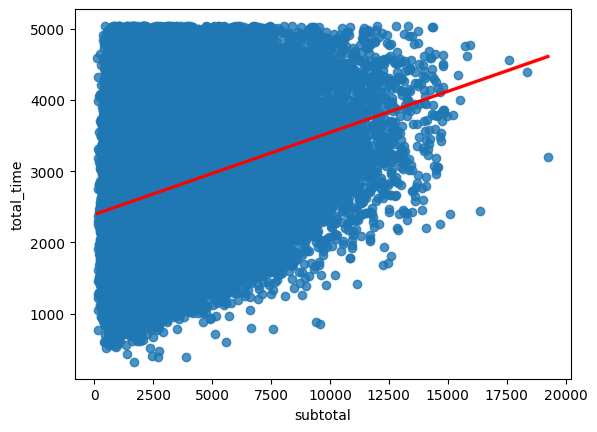

In [58]:
sns.regplot(x='subtotal',y="total_time", data=doordash_data, line_kws={"color": "red"})

This shows that if the subtotal amount of an order is higher, the amount of time needed to deliver the order is also higher

<Axes: xlabel='total_outstanding_orders', ylabel='total_time'>

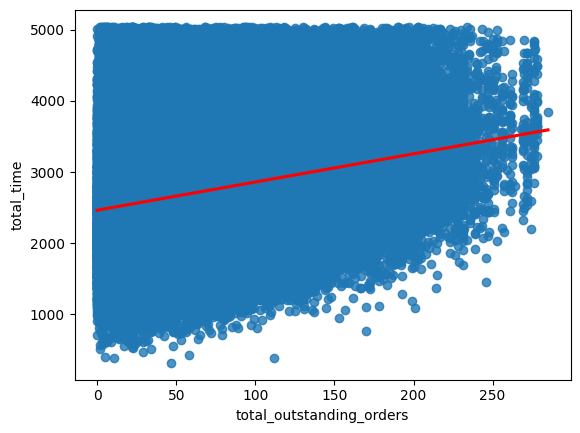

In [59]:
sns.regplot(x='total_outstanding_orders',y="total_time", data=doordash_data, line_kws={"color": "red"})

This shows that if the total number of outstanding orders among 10 miles of this order is more, the amount of time needed to deliver the order is also higher

<Axes: xlabel='busy_dashers_ratio', ylabel='total_time'>

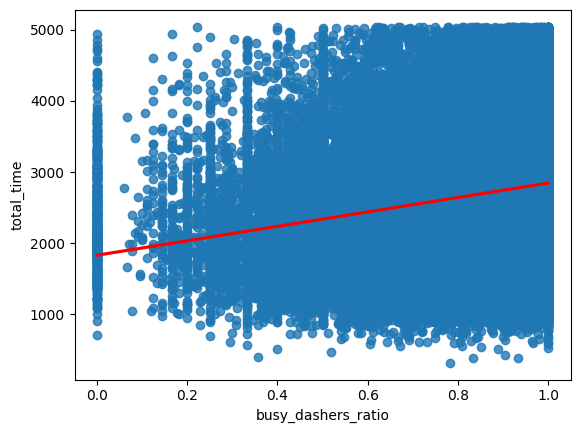

In [60]:
sns.regplot(x='busy_dashers_ratio',y="total_time", data=doordash_data, line_kws={"color": "red"})

This shows that if the ratio of busy dashers out of onshift dashers within 10 miles is higher, the amount of time needed to deliver the order is also higher

<Axes: xlabel='total_items', ylabel='total_time'>

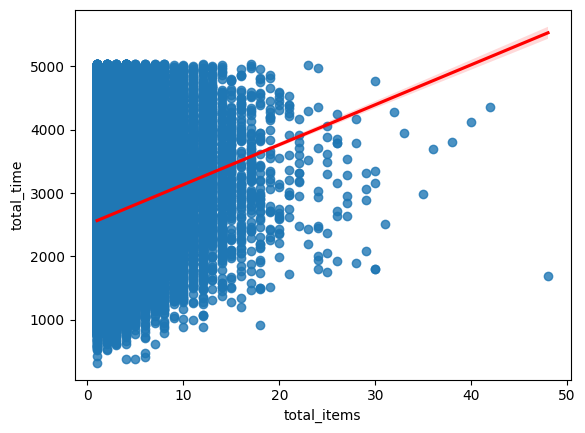

In [61]:
sns.regplot(x='total_items',y="total_time", data=doordash_data, line_kws={"color": "red"})

This shows that if the total number of items in an order is more, the amount of time needed to deliver the order is also higher. This graph also shows that it is less frequent to have a high number of total items, most of them is less than 10. To examine further, we will do a histogram:

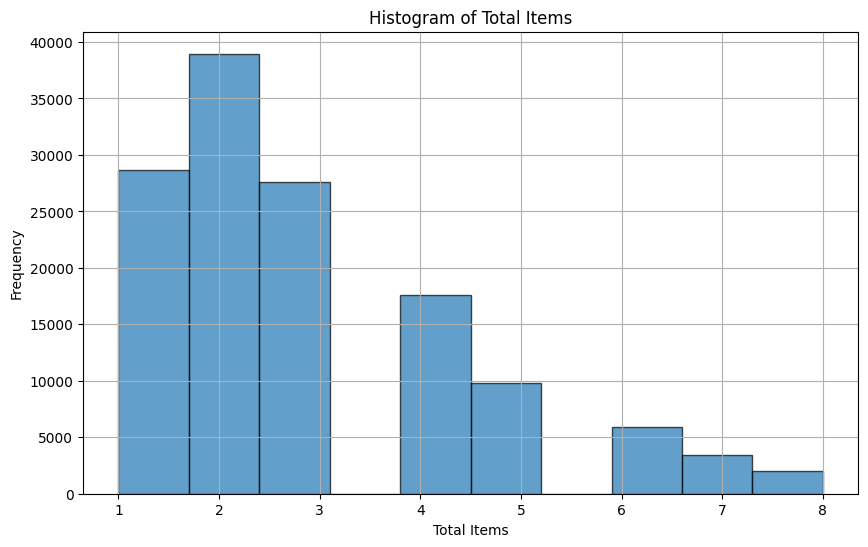

In [62]:
plt.figure(figsize=(10, 6))
plt.hist(doordash_data[doordash_data['total_items'] <= 8]['total_items'],edgecolor='k', alpha=0.7)
plt.xlabel('Total Items')
plt.ylabel('Frequency')
plt.title('Histogram of Total Items')
plt.grid(True)
plt.show()

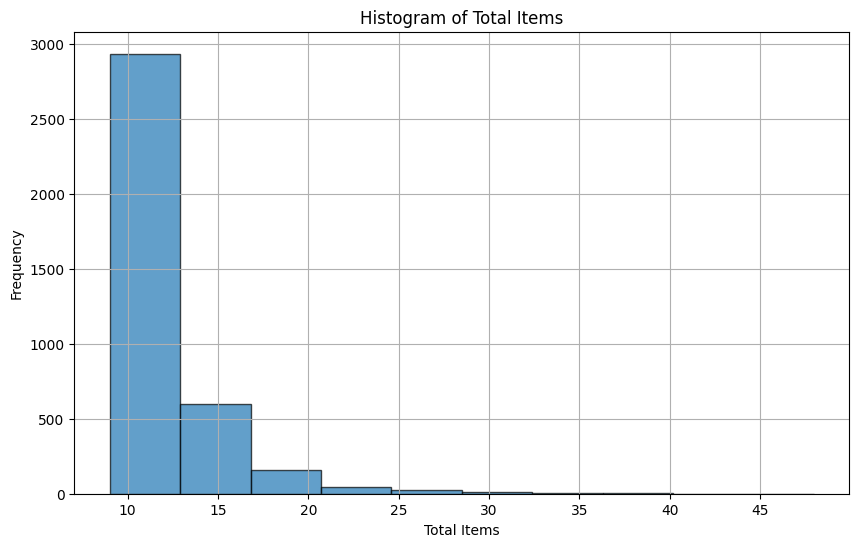

In [63]:
plt.figure(figsize=(10, 6))
plt.hist(doordash_data[doordash_data['total_items'] > 8]['total_items'],edgecolor='k', alpha=0.7)
plt.xlabel('Total Items')
plt.ylabel('Frequency')
plt.title('Histogram of Total Items')
plt.grid(True)
plt.show()

We could see that most of the orders only have 1 - 2 items in the order. When the number of items increase, the occurence of that order is less and less. We could put them into different bins, because we would like to take frequency into consideration. We will split them into five bins, the first fourth with 2 bin size and the last one includes the rest. Because 1 -2 items happen most frequently, it won't be that helpful in identifying the total delivery time, but the rest of the bins might help because it is less frequent and we know that longer delivery time is with more total items.

#### Further feature engineering

In [64]:
# Five bins, each with two bin size except the last one for the rest
bin_edges = [0, 2, 4, 6, 8, np.inf]
bin_labels = ['1-2', '3-4', '5-6', '7-8', '9+']

In [65]:
# Make a new column based on the bin labels
doordash_data.loc[:, 'total_items_binned'] = pd.cut(doordash_data['total_items'], bins=bin_edges, labels=bin_labels, right=False)

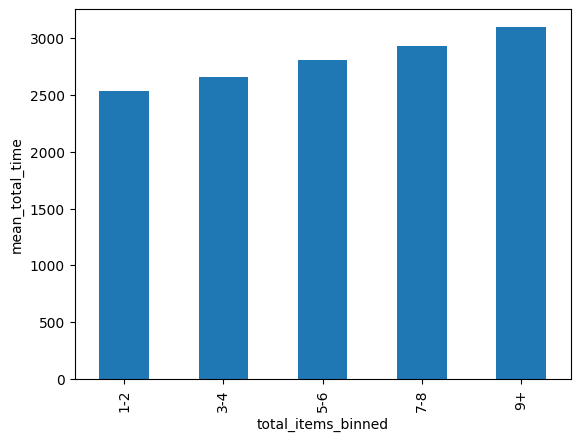

In [66]:
doordash_data.groupby('total_items_binned')['total_time'].mean().plot.bar()
plt.ylabel('mean_total_time')
plt.show()

We could see that the mean of the total delivery items is higher for the bins with higher number of items in an order, aligning with the regression plot earlier.

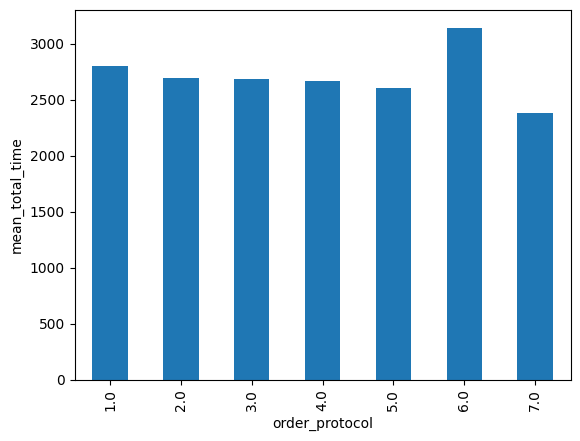

In [67]:
doordash_data.groupby('order_protocol')['total_time'].mean().plot.bar()
plt.ylabel('mean_total_time')
plt.show()

Order protocol refers to the way the restaurant takes order. From Doordash website (https://help.doordash.com/merchants/s/article/What-order-protocol-should-I-choose-Tablet-email-or-fax?language=en_CA&ctry=CA&divcode=ON), we know that sizes of restaurant will tend to choose different protocols due to the cost for that. For example, POS integration is usually for larger size restaurants, and they will have the capability to take order quicker; email protocol is usually for smaller size restaurants, and they will work slower on an order. From the above, protocol 6 has the highest mean of total deliver time, suggesting that it could be smaller restaurants using email or another protocol that will take more time for them to receive an order. This will also help the model predict the time better because different protocol contributes to longer or shorter delivery time.

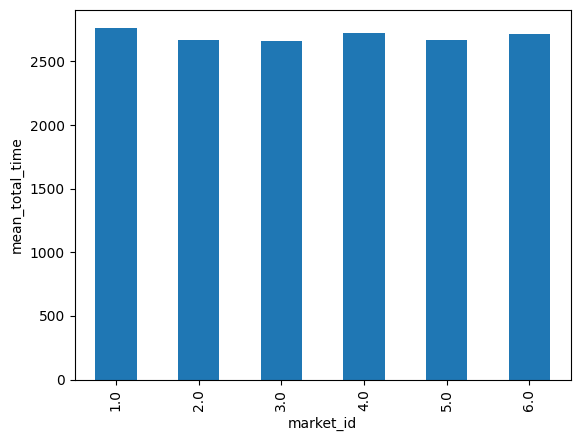

In [68]:
doordash_data.groupby('market_id')['total_time'].mean().plot.bar()
plt.ylabel('mean_total_time')
plt.show()

Each market represents each district Doordash has coverage on. The total delivery time could depend on the size of the district. For example, in a busier district, it could take more time to deliver an order because there are too many other orders placed at the same time; in a smaller district, it could take less time to deliver an order because everyone lives closer and less outstanding orders.

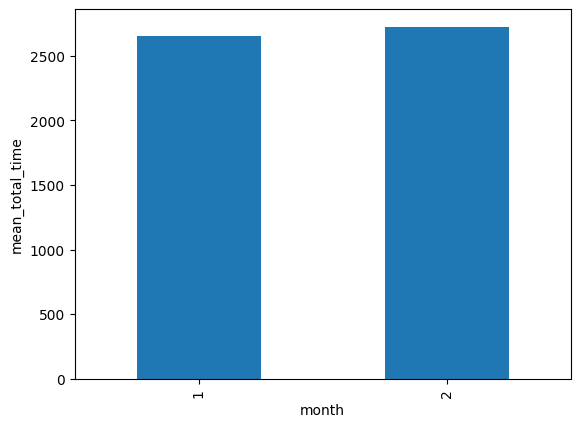

In [69]:
doordash_data.groupby('month')['total_time'].mean().plot.bar()
plt.ylabel('mean_total_time')
plt.show()

We only have January and February data, and we could see the average delivery time of the order is higher in February.

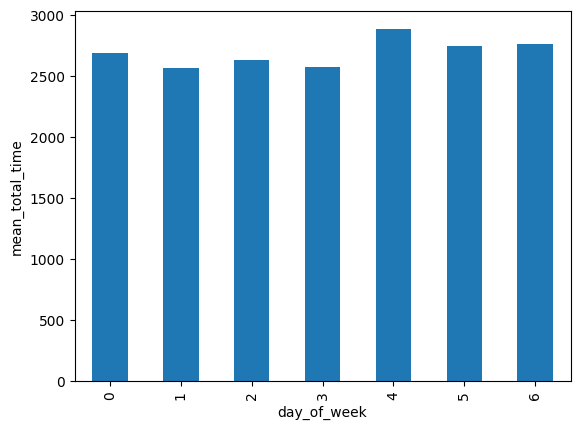

In [70]:
doordash_data.groupby('day_of_week')['total_time'].mean().plot.bar()
plt.ylabel('mean_total_time')
plt.show()

0 is Monday; 6 is Sunday. The average total time taken for an order is highest on Friday, which could be due to the fact that more orders but less dashers working that day.

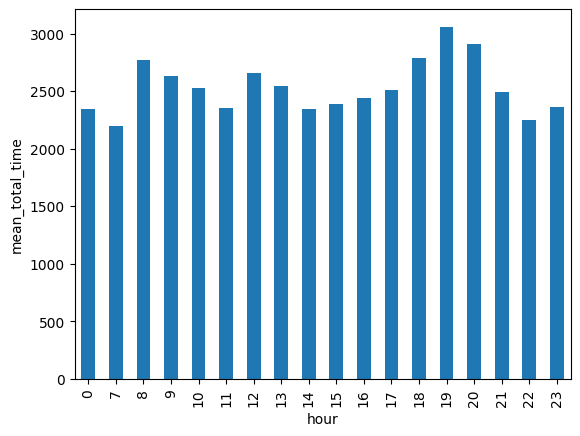

In [71]:
doordash_data.groupby('hour')['total_time'].mean().plot.bar()
plt.ylabel('mean_total_time')
plt.show()

Hour is in PST because of the data conversion done at the beginning, and it is the hour the order was created. It shows that no one order during 0 - 7 PST, suggesting the districts doordash operated was in the west coast of North America. The average deliver time is the longest at 7 PM, mostly because people just wanted to get food delivery for their dinner after work, so it was the busiest time.

## Data Processing

In [72]:
# Reset index for dataframe concatenation in the next step
doordash_data = doordash_data.reset_index(drop=True)

In [73]:
# Make dummy columns for the order protocol, because the protocol is a variable that is strongly correlated to the estimated
# time for the restaurant to recieve the order. For example if it is email protocol, it will take longer time.
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(doordash_data[['order_protocol']])
one_hot_encoded_protocol = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(['order_protocol']))

In [74]:
# Make dummy columns for the total items binned, because it is not a numeric variable, and it is strongly correlated to the
# subtotal value in an order. If there are more items, the subtotal is higher
one_hot_encoded = one_hot_encoder.fit_transform(doordash_data[['total_items_binned']])
one_hot_encoded_binned_items = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(['total_items_binned']))

In [75]:
# Dropping columns that will not be examined anymore because of the data conversion done abvoe
doordash_data_2 = doordash_data.drop(['created_at', 
                               'actual_delivery_time', 
                               'order_protocol',
                               'store_primary_category',
                               'num_distinct_items',
                               'min_item_price',
                               'max_item_price',
                               'total_items',
                               'total_items_binned',      
                               'total_onshift_dashers',
                               'total_busy_dashers',
                               'created_at_date_pst',
                               'actual_delivery_time_date_pst'], axis=1)

In [76]:
# The added features max_min_price_same and all_items_distinct are categorical variable of 0 and 1, so no scaling is needed
# Other items are variable features or categorical features that have values more than 1, so it has to be scaled
scaler = StandardScaler()
doordash_for_scale = doordash_data_2.drop(['max_min_price_same', 'all_items_distinct'], axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(doordash_for_scale), columns=doordash_for_scale.columns)

In [77]:
# Concatenate numeric, categorical and dummy variables
doordash_data_3 = pd.concat([scaled_data, 
                             one_hot_encoded_protocol, 
                             one_hot_encoded_binned_items, 
                             doordash_data_2[['max_min_price_same', 'all_items_distinct']]], axis=1)

In [78]:
# No missing values
doordash_data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137825 entries, 0 to 137824
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     137825 non-null  float64
 1   store_id                                      137825 non-null  float64
 2   subtotal                                      137825 non-null  float64
 3   total_outstanding_orders                      137825 non-null  float64
 4   estimated_order_place_duration                137825 non-null  float64
 5   estimated_store_to_consumer_driving_duration  137825 non-null  float64
 6   total_time                                    137825 non-null  float64
 7   month                                         137825 non-null  float64
 8   day_of_week                                   137825 non-null  float64
 9   hour                                          13

### Multicollinearity

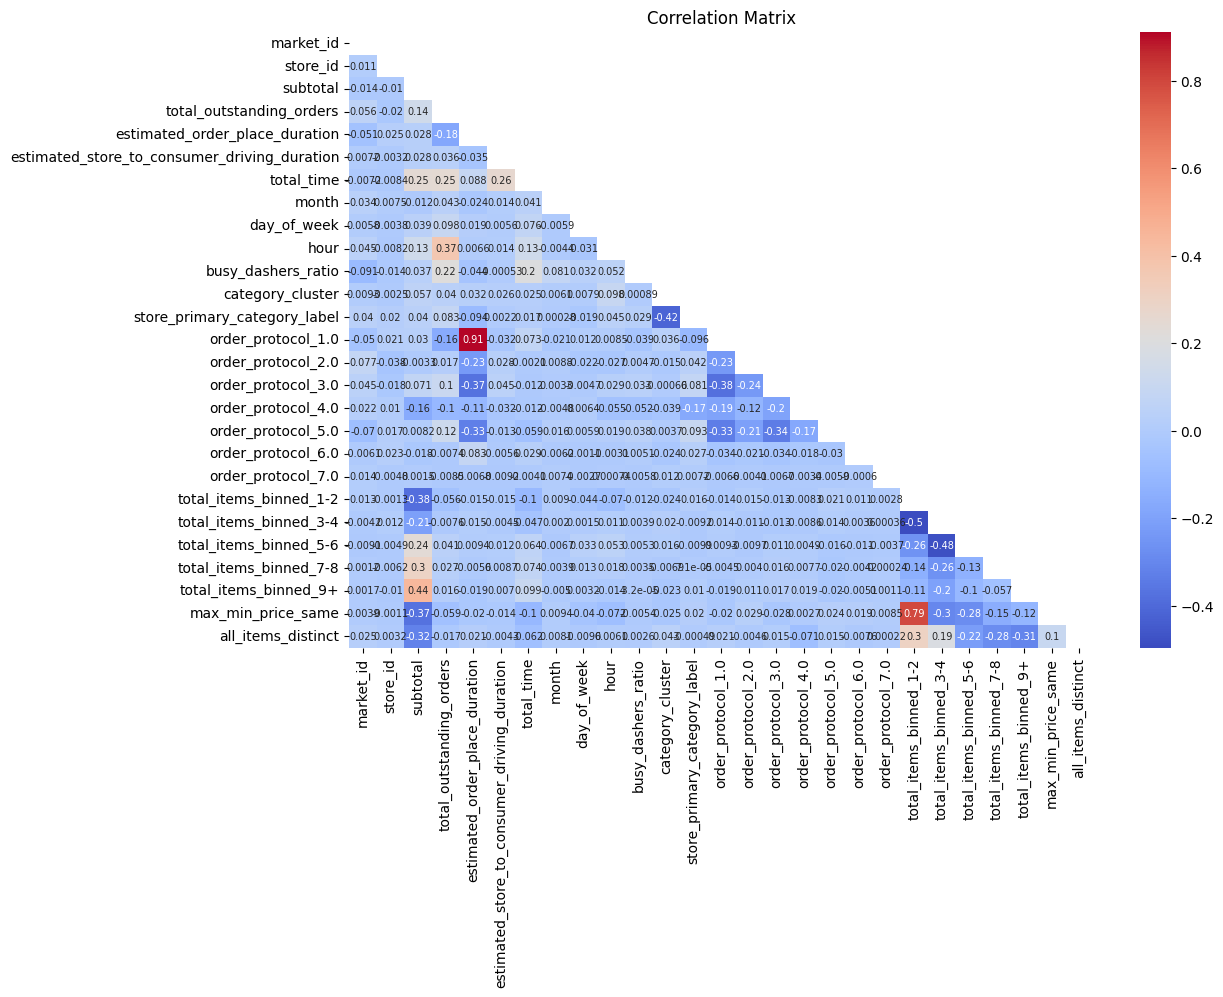

In [79]:
# Check the correlation between variables
corr_matrix = doordash_data_3.corr()
mask=np.triu(corr_matrix)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', annot_kws={"fontsize": 7})
plt.title('Correlation Matrix')
plt.show()

In [80]:
# There are two variables with high correlation with other variables, which are bigger than 0.5
# They will be removed from the dataframe
doordash_data_4 = doordash_data_3.drop(['total_items_binned_1-2', 'order_protocol_1.0'], axis=1)

In [81]:
# To calculate VIF, we don't need the output variable
features_VIF = doordash_data_4.drop(['total_time'], axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = features_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(features_VIF.values, i) for i in range(features_VIF.shape[1])]
print(vif_data)

                                         feature       VIF
0                                      market_id  1.034121
1                                       store_id  1.004311
2                                       subtotal  1.969574
3                       total_outstanding_orders  1.315540
4                 estimated_order_place_duration  4.922328
5   estimated_store_to_consumer_driving_duration  1.006138
6                                          month  1.010457
7                                    day_of_week  1.020826
8                                           hour  1.206267
9                             busy_dashers_ratio  1.070201
10                              category_cluster  1.260693
11                  store_primary_category_label  1.302877
12                            order_protocol_2.0  3.818855
13                            order_protocol_3.0  7.118431
14                            order_protocol_4.0  2.647258
15                            order_protocol_5.0  6.0410

Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. As a rule of thumb, any variable with a VIF value less than 5.0 will not suffer from multicollinearity problem. From the above, it shows that two of the variables are higher than 5.0: order_protocol_3.0 and order_protocol_5.0. We are not going to remove them in this case, because they are just dummy variables and it will have signficiant correlation with other dummy variables. To tackle this, we will be using models that could handle multicollinearity issues well.

In [82]:
# Features used in the dataset is just the features we examined using VIF
features = features_VIF
# Outupt is the total delivery time
target = doordash_data_4['total_time']

## Dimensionality

In [85]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge


lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)
print(mean_squared_error(y_test, y_pred_lin))
print(mean_absolute_error(y_test, y_pred_lin))
print(np.sqrt(mean_squared_error(y_test, y_pred_lin)))

In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print(mean_squared_error(y_test, y_pred_lasso))
print(mean_absolute_error(y_test, y_pred_lasso))
print(np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

In [ ]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print(mean_squared_error(y_test, y_pred_ridge))
print(mean_absolute_error(y_test, y_pred_ridge))
print(np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

In [ ]:
list(ridge.coef_)

In [86]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)

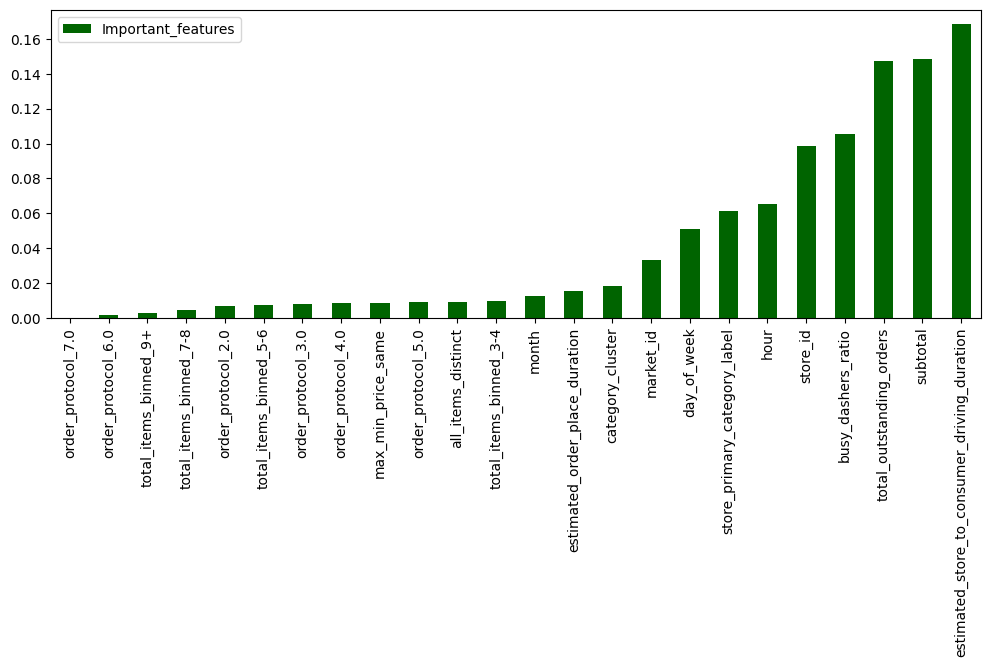

In [87]:
feat_dic = {}
# Add the feature name and importance score to the dictionary
for feature, importance in zip(features.columns, rf.feature_importances_):
    feat_dic[feature] = importance

# sort the DataFrame by feature importance and create a bar chart
importances = pd.DataFrame.from_dict(feat_dic, orient='index').rename(columns={0: 'Important_features'})
importances.sort_values(by='Important_features').plot(kind='bar', rot=90, figsize=(12,4), color='darkgreen')
plt.show()

From the graph above, it shows that 9 variables have importance score of more 0.02. Using that as a threshold, we just need to pick these 9 variables because other variables wouldn't really help getting a more accurate delivery time, and this will help address dimensionality issue. We will then review the PVC curve next

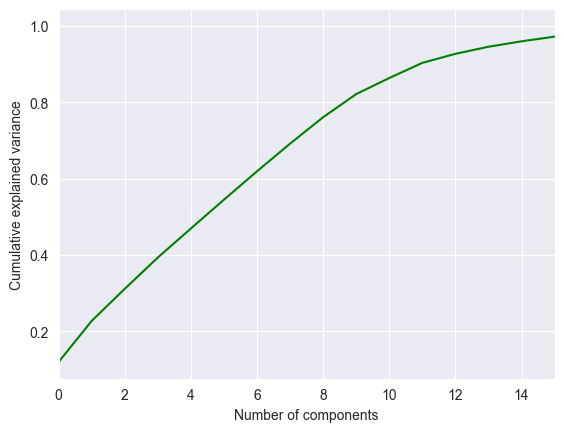

In [88]:
# plot a PCA to understand the minimum number of input variables to explain the x% variance of the output variable
pca = PCA().fit(features)
sns.set_style('darkgrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'green')
plt.xlim(0,15)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

The PCA curve above aligns with the feature importance anylsis. When there are 9 components, it could have 80% explained variance. To have 90% explained variance, we could have around 12 components, which are the variables with around 0.01 or above importance score in the feature importance analysis. If 12 most important features are included, the reamining ones are the dummies and categorical variable. They will not be necessarily needed to be removed. Also, as mentioned in the multicollinearity section, we are going to use models that could handle multicollinearity well, and it will also handle dimensionality issues well.

## Models Building

### Advanced Traditional Algorithms comparison using cross validation

In [137]:
# Following are the advanced traditional algorithms we are going to compare. These are known to give good results
gbr = GradientBoostingRegressor(random_state=42)
hgbr = HistGradientBoostingRegressor(random_state=42)
XGB = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
svr = SVR(kernel='rbf')

In [138]:
# Train the models using cross validations for 5 times
GraidentBoosting = cross_val_score(gbr, X_train, y_train, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1,)
HistGradientBoosting = cross_val_score(hgbr, X_train, y_train, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
XGBR = cross_val_score(XGB, X_train, y_train, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
RandomForest = cross_val_score(rf, X_train, y_train, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
SVR = cross_val_score(svr, X_train, y_train, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.6s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parall

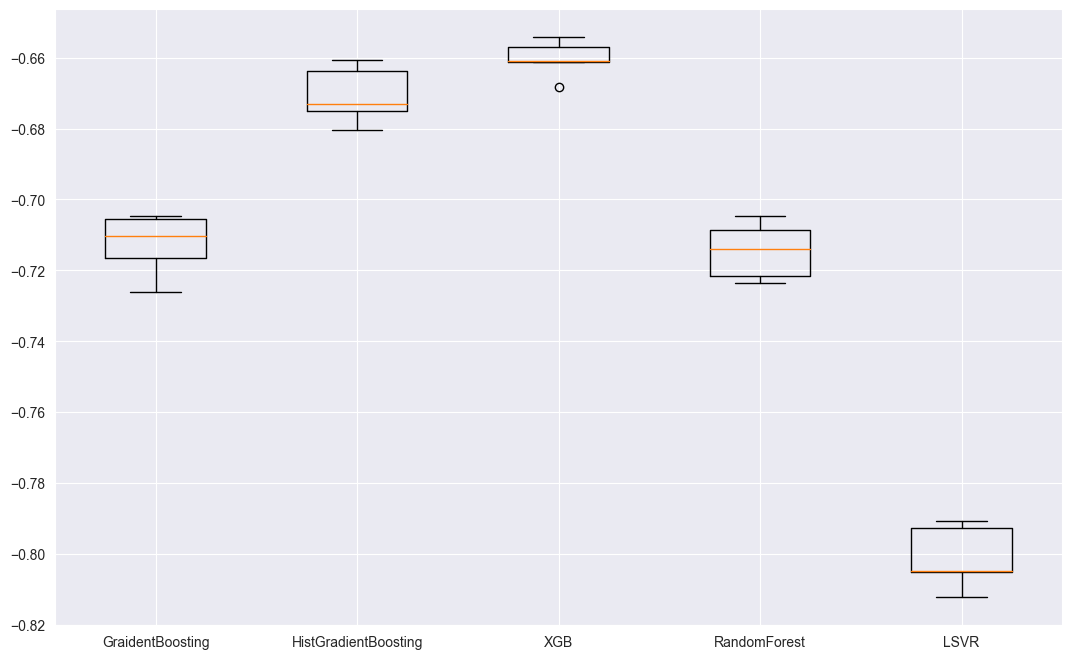

In [141]:
# Plot the scores of each model based on the mean squared error
model_scores = [
    ('GraidentBoosting', GraidentBoosting),
    ('HistGradientBoosting', HistGradientBoosting),
    ('XGB', XGBR),
    ('RandomForest', RandomForest),
    ('SVR', SVR)
]

plt.figure(figsize=(13,8))
plt.boxplot([mod[1] for mod in model_scores],
            labels=[mod[0] for mod in model_scores])
plt.show()

The above graph shows that XGBoost regressor has the best performance among all, as the range of the five mean squared error from the cross validations are generally lower than all the others, with HistGradientBoosting regressor has a closer performance. Due to this, we could tune the hyperparameters for XGBoost regressor to see if we can push the mean squared error lower.

In [181]:
def plot_learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1)
    
    # Calculate mean and standard deviation
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")
    
    plt.xlabel("Training Examples")
    plt.ylabel("Mean Squared Error")
    plt.title("XGBoost Regressor Learning Curves")
    plt.legend(loc="best")
    
    plt.show()

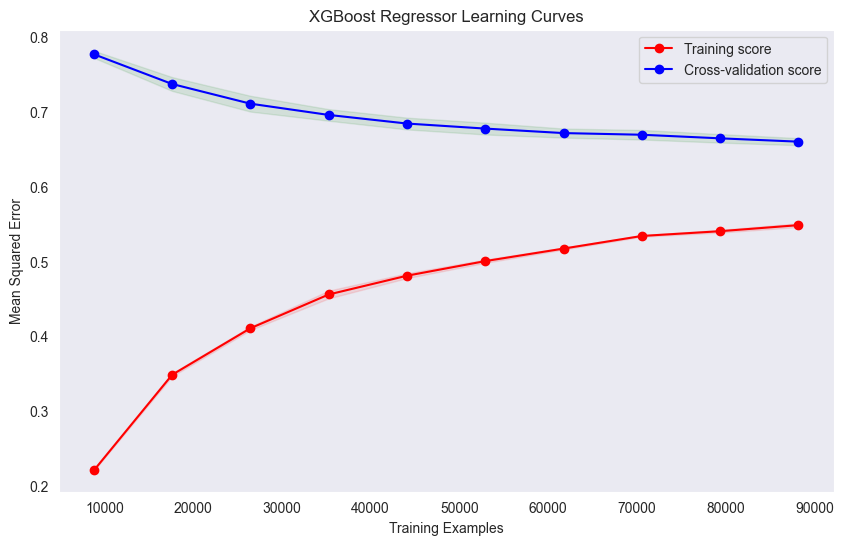

In [182]:
plot_learning_curve(XGB, X_train, y_train)

From the above learning curve, the training mean squared error started from low and gradually got higher, reaching a level that does not increase much. Similarly, the cross-validation mean squared error started high and gradually got lower, reaching a level that does not decrease much. Given that, this is ideal learning curves for the XGBoost Regressor and we know that it is a good model.

### Randomized Search for XGB Regressor

In [167]:
# Parameter distributions for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

In [168]:
random_search = RandomizedSearchCV(estimator=XGB, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found by Randomized Search:", random_search.best_params_)
print("Best score found by Randomized Search:", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found by Randomized Search: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
Best score found by Randomized Search: 0.653202860115889


From the above, we see that the hyperparameters can be tuned to get a better performing model for XGBoost Regressor, and the mean squared error is slightly lower using this set of hyperparameters

In [169]:
best_xgb_random = random_search.best_estimator_

In [170]:
# Use cross validation to confirm the performance of the model
cross_val_score(best_xgb_random, X_train, y_train, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


array([-0.64322538, -0.65077113, -0.64170316, -0.6544912 , -0.65205438])

The mean squared error stayed at around 0.65 after running 5 times, proving that it is pretty robust and that is the lowest mean squared error it could reach.

### Neural Network

In [154]:
'''
Function defined to create and compile a Neural Network model
@learning_rate: Learning rate of the Adam optimizer
@activation: Activation function used in the neural network
@dropout_rate: Dropout rate for the dropout layer of the neural network. Default is 0, meaning no dropout layer is added
@l2: regularization rate for l2 regularization
'''
def create_model(learning_rate, activation, dropout_rate=0.0, l2=0.0):
    model = Sequential()
    # Input layer
    model.add(Dense(64, input_dim=features.shape[1], activation=activation, kernel_regularizer=regularizers.l2(l2=l2)))
    model.add(BatchNormalization())
    
    # Hidden layers
    model.add(Dense(32, activation=activation, kernel_regularizer=regularizers.l2(l2=l2)))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(16, activation=activation, kernel_regularizer=regularizers.l2(l2=l2)))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='linear'))
    
    # Use Adam for compiler because it is known to have better performance
    model.compile(Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [196]:
model = create_model(0.005, 'relu', 0.3, 0)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
3102/3102 [==============================] - 3s 956us/step - loss: 0.8201 - val_loss: 0.7383
Epoch 2/100
3102/3102 [==============================] - 3s 919us/step - loss: 0.7798 - val_loss: 0.7387
Epoch 3/100
3102/3102 [==============================] - 3s 894us/step - loss: 0.7685 - val_loss: 0.7153
Epoch 4/100
3102/3102 [==============================] - 3s 873us/step - loss: 0.7628 - val_loss: 0.7096
Epoch 5/100
3102/3102 [==============================] - 3s 884us/step - loss: 0.7618 - val_loss: 0.7142
Epoch 6/100
3102/3102 [==============================] - 3s 891us/step - loss: 0.7590 - val_loss: 0.7148
Epoch 7/100
3102/3102 [==============================] - 3s 893us/step - loss: 0.7581 - val_loss: 0.7066
Epoch 8/100
3102/3102 [==============================] - 3s 899us/step - loss: 0.7572 - val_loss: 0.7067
Epoch 9/100
3102/3102 [==============================] - 3s 915us/step - loss: 0.7533 - val_loss: 0.7036
Epoch 10/100
3102/3102 [==============================]

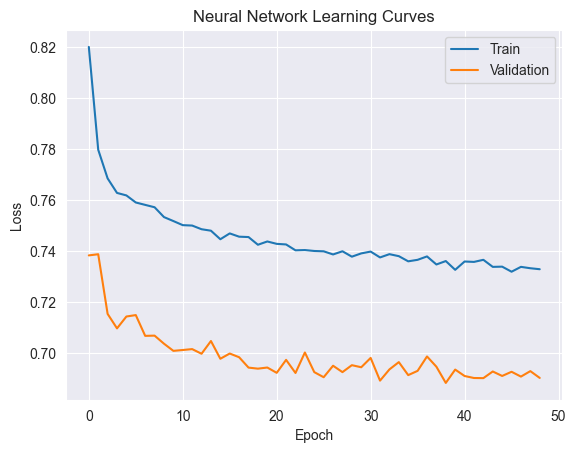

In [198]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neural Network Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

From the learning curves above, both validation loss and training loss started high, then gradually decreased and reached a constant level after several epochs. It is reasonably good for neural networks. However, the loss fluctuated a lot, as it went up and down after each epoch even the overall trend is decreasing, suggesting it is not that stable. Also, the training and validation loss failed to converge, which means it might not be able to explain the output in the test set that well. 

In [199]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predicting on test data
y_pred = model.predict(X_test)

862/862 [==============================] - 0s 449us/step - loss: 0.6976
Test Loss: 0.697608232498169
862/862 [==============================] - 0s 439us/step


In [205]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 0.6618135727613755
Mean Squared Error: 0.6976083514226628


Given what was observed in the learning curves, the mean squared error between the prediction and test dataset is better than expected, because it could still be lower than 0.7. Compared to XGBoost Regressor, it is still a little worse off.

### Grid Search for Neural network

In [159]:
# Wrap the Keras model for use in scikit-learn
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=64, verbose=0)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'activation': ['relu', 'tanh', 'leaky_relu'],
    'dropout_rate': [0, 0.2, 0.5],
    'l2': [0, 0.1, 0.001]
} 

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_result.best_params_}")
print(f"Best RMSE found: {(-grid_result.best_score_)**0.5}")

# Get the best model
best_model = grid_result.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate RMSE on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse}")

C:\Users\Reynold Jong\AppData\Local\Temp\ipykernel_32176\3805089124.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=64, verbose=0)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\Reynold Jong\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: {'activation': 'relu', 'dropout_rate': 0, 'l2': 0, 'learning_rate': 0.01}
Best RMSE found: 0.8349416896670161
Test RMSE: 0.8344382833286575


From the above, we know that the model has a lower root mean squared error using relu activation function and lower learning rate, without any regularization given the number of neurons and layer of neural networks remain the same. However, the model will suffer from overfitting issue if we use the exact same set of values for regularization. As a result, certain level of regularization is still needed to reduce the overfitting issue. From the section when neural network first ran, it will be a better choice to have a slightly lower learning rate and low dropout rate for the dropout layer to prevent overfitting issue.

## Conclusion

To conclude, the better performing model among all the six models is the XGB Regressor model. After tuning hyperparameters the mean squared error is the lowest among all. The neural network may have more potential because of the number of hyperparameters it could be changed. Yet, it might not be that suitable in this case because it could be too complex to explain the data. If we are looking for improving both the neural network and XGBoost Regressor models, we will need more training data and hopefully better quality data, ensuring the variables can better explain the total delivery time output. Other than that, we could experiment with more features by conducting further feature engineering and hyperparameters tuning for the model.